In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ldc.lisa.orbits import Orbits
from ldc.common.series import TDI
import ldc.waveform.fastGB as fastGB
from ldc.lisa.projection import ProjectedStrain
from ldc.waveform.waveform import HpHc
from ldc.common.series import TimeSeries
import ldc.io.hdf5 as h5io
from ldc.common.tools import window
from ldc.lisa.noise import get_noise_model

/usr/lib/python3.9/typing.py:984: FutureWarning: xarray subclass TDI should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


## Diagnostic

With a simple grid approach, we look for bias in GB parameters, when fitting sangria like data with FastGB.

In [2]:
pGB = dict({"Frequency":0.0109966533684,
            "FrequencyDerivative": 2.95291919174e-14, 
            "EclipticLatitude":-0.150495923831, 
            "EclipticLongitude":4.60685356883, 
            "Amplitude":2.60186425363e-22,
            "Inclination":0.389613740033,
            "Polarization":0.605754423063,
            "InitialPhase":4.54588971721})

### The data

In [3]:
## Noiseless Sangria data
tdi, descr = h5io.load_array("/home/maude/data/LDC/sangria/1.7/dgb-tdi-XYZ.h5")
dt = tdi['t'][1]-tdi['t'][0]
tdi_sangria_x = TimeSeries(tdi["X"], dt=dt, t0=tdi["t"][0])
tdi_sangria_y = TimeSeries(tdi["Y"], dt=dt, t0=tdi["t"][0])
tdi_sangria_z = TimeSeries(tdi["Z"], dt=dt, t0=tdi["t"][0])
tdi_sangria_fd = TDI(dict({"X":tdi_sangria_x.ts.fft(win=window),
                           "Y":tdi_sangria_y.ts.fft(win=window),
                           "Z":tdi_sangria_z.ts.fft(win=window)}))
tdi_sangria_fd.XYZ2AET()

In [4]:
## Alternatively: use LDC toolbox to build a time domain noise free signal, for this source

#Proj = ProjectedStrain(lisa_orbits)
#GW = HpHc.type("debug", "GB", "TD_fdot")
#GW.set_param(pGB)
#yArm = Proj.arm_response(t_min, t_max, dt, [GW])
#tdi_x = TimeSeries(Proj.compute_tdi_x(tdi_sangria_x.t.values), dt=dt)
#tdi_y = TimeSeries(Proj.compute_tdi_y(tdi_sangria_x.t.values), dt=dt)
#tdi_z = TimeSeries(Proj.compute_tdi_z(tdi_sangria_x.t.values), dt=dt)
#tdi_fd = TDI(dict({"X":tdi_x.ts.fft(win=window), "Y":tdi_y.ts.fft(win=window), "Z":tdi_z.ts.fft(win=window)}))
#tdi_fd.XYZ2AET()

### The template

In [5]:
## FastGB: to match the freq vector, we deduce Tobs (thus df) from above
dt = 15 # waveform sampling
t_max = tdi_sangria_x.t[-1]+tdi_sangria_x.attrs['dt'] # time of observation = 1yr
t_min = tdi_sangria_x.t[0]
oversample = 4

config = {"initial_position": 0, "initial_rotation": 0, 
          "nominal_arm_length": 2500000000, "orbit_type": 'analytic'}
lisa_orbits = Orbits.type(config)

## FASTGB
GB = fastGB.FastGB(delta_t=dt, T=t_max, orbits=lisa_orbits) # in seconds
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=oversample, simulator='synthlisa')
fast = TDI(dict(zip(["X", "Y", "Z"], [Xs, Ys, Zs])))
fast.XYZ2AET()

### Quicklook

Text(0, 0.5, 'E (imag part)')

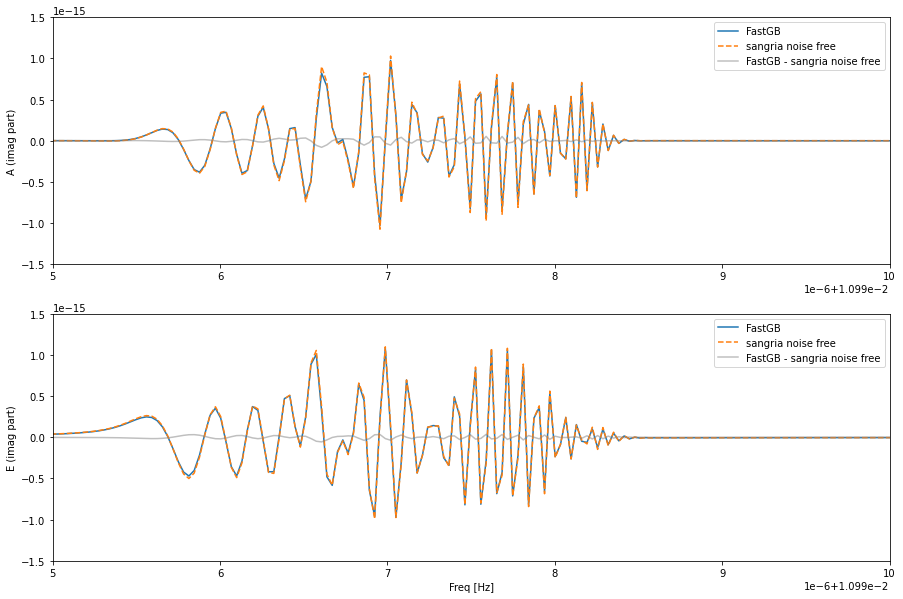

In [6]:
subset_sangria = tdi_sangria_fd.sel(f=fast.f, method="nearest")
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(fast.f, fast["A"].imag, label='FastGB')
#plt.plot(tdi_fd.f, tdi_fd["A"].imag, label='sangria like')
plt.plot(tdi_sangria_fd.f, tdi_sangria_fd["A"].imag,  label='sangria noise free', ls='--')
plt.plot(fast.f, fast["A"].values.imag-subset_sangria.A.values.imag, alpha=0.5, color='grey', label='FastGB - sangria noise free')
#plt.plot(fast.f, fast["A"].imag-subset.A.imag, alpha=0.5, color='grey', label='FastGB - sangria like')
plt.axis([0.010995, 0.01100, -1.5e-15, 1.5e-15])
plt.legend()
plt.ylabel("A (imag part)")
plt.subplot(212)
plt.plot(fast.f, fast["E"].imag, label='FastGB')
#plt.plot(tdi_fd.f, tdi_fd["E"].imag,  label='sangria like')
plt.plot(tdi_sangria_fd.f, tdi_sangria_fd["E"].imag,  label='sangria noise free', ls='--')
plt.plot(fast.f, fast["E"].values.imag-subset_sangria.E.values.imag, alpha=0.5, color='grey', label='FastGB - sangria noise free')
#plt.plot(fast.f, fast["E"].imag-subset.E.imag, alpha=0.5, color='grey', label='FastGB - sangria like')
plt.axis([0.010995, 0.01100, -1.5e-15, 1.5e-15])
plt.legend()
plt.xlabel("Freq [Hz]")
plt.ylabel("E (imag part)")

### Log-likelihood sampling

We compute the log-likelihood which each parameter slightly movin from its true value. 

In [7]:
fr_min = 0.010991945713229392
fr_max = 0.011002061136872575

def MakePrior1Src(fr_min, fr_max):
    Amp_bnd = [-24.0, -20.0] ### log10 amplitude
    fr_bnd = np.array([fr_min, fr_max]) ### in Hz
    fdot_bnd = [-1.e-13, 1.e-13]  ### fdot
    sin_bet_bnd = [-1.0, 1.0]
    lam_bnd = [0.0, 2.0*np.pi]
    cos_iota_bnd = [-1.0, 1.0]
    psi_bnd = [-2.0*np.pi, 4.0*np.pi]
    phi0_bnd = [-2.0*np.pi, 4.0*np.pi]
    prior = [Amp_bnd, fr_bnd, fdot_bnd, sin_bet_bnd, lam_bnd, cos_iota_bnd, psi_bnd, phi0_bnd]
    prior = np.array(prior)
    return (prior)

prior = MakePrior1Src(fr_min, fr_max)

def loglikelihood_dgb(p, full_output=False):
    logA, fr, fdot, sinb, lam, ci, psi, phi0 = p
    inPrior = True

    for i in range(len(p)):
        if (p[i] < prior[i,0] or p[i]>prior[i,1]):
                inPrior=False
    if not inPrior:
        return (-np.inf)
    
    tmpl = dict({"Frequency": fr,
                 "FrequencyDerivative": fdot, 
                 "EclipticLatitude": np.arcsin(sinb), 
                 "EclipticLongitude": lam, 
                 "Amplitude": 10**logA,
                 "Inclination": np.arccos(ci),
                 "Polarization": psi,
                 "InitialPhase": phi0})

    Xs, Ys, Zs = GB.get_fd_tdixyz(template=tmpl, oversample=oversample, simulator='synthlisa')
    tdi = TDI(dict({"X":Xs, "Y":Ys, "Z":Zs}))
    tdi.XYZ2AET()
    
    ### overlapping range for the signal
    if (Xs.f[-1] <= fr_min):
        return (-np.inf)
    elif (Xs.f[0] >= fr_max):
        return (-np.inf)

    subset = tdi.sel(f=slice(fr_min, fr_max))
    freq = np.array(subset.f); df=freq[1]-freq[0]
    At = subset.A.values
    Et = subset.E.values
    
    ### overlapping range for the data
    dsubset = tdi_sangria_fd.sel(f=slice(fr_min, fr_max))
    #dsubset = tdi_fd.sel(f=slice(fr_min, fr_max))
    As = dsubset.A.values
    Es = dsubset.E.values

    #At = tdi['A'].interp(f=dsubset.f).values
    #Et = tdi['E'].interp(f=dsubset.f).values

    SA = get_noise_model('SciRDv1', frq=freq).psd(option='A')
    
    sn1 = np.sum(np.real(As*np.conjugate(At) + Es*np.conjugate(Et))/SA )
    sn2 = np.sum((np.abs(At)**2 + np.abs(Et)**2)/SA)
    sn0 = np.sum((np.abs(As)**2 + np.abs(Es)**2)/SA)
    loglik = 4.0*df*(sn1 - 0.5*sn2)

    if full_output:
        sn1ae = (np.real(As*np.conjugate(At) + Es*np.conjugate(Et))/SA )
        sn2ae = ((np.abs(At)**2 + np.abs(Et)**2)/SA)
        loglikAE = 4.0*df*(sn1ae - 0.5*sn2ae)
        return loglik, loglikAE, freq
    return loglik


loglik =  59776.012397631515  ~ snr =  345.7629604154601


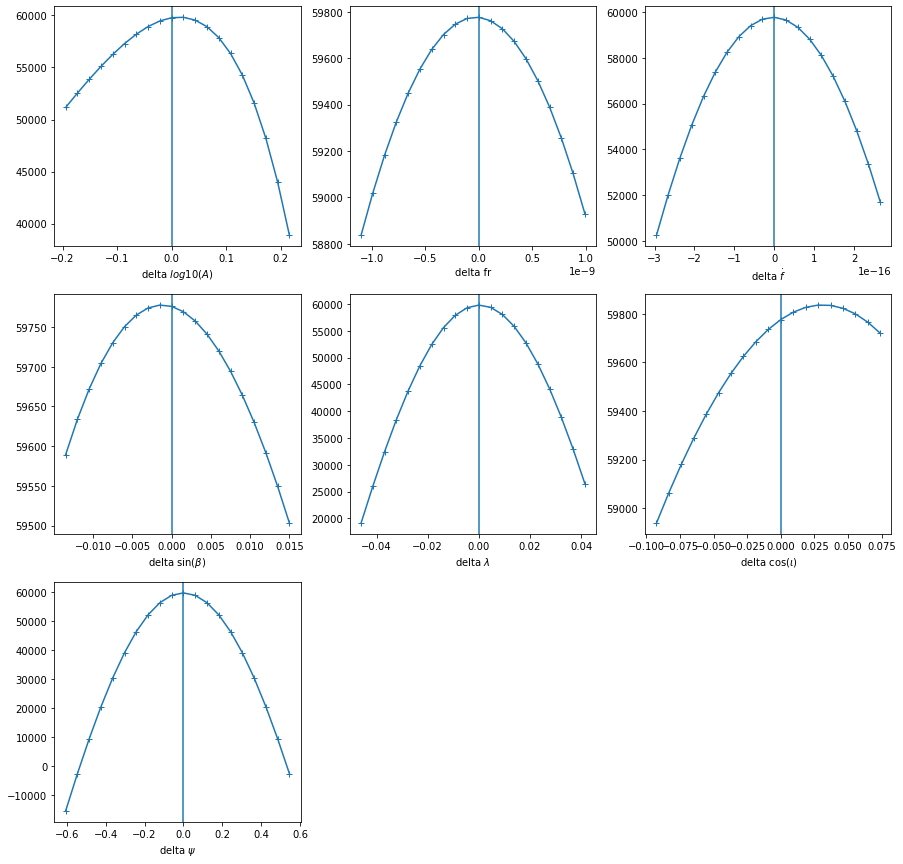

In [8]:
p = [np.log10(pGB['Amplitude']),  pGB['Frequency'], pGB['FrequencyDerivative'], np.sin(pGB['EclipticLatitude']), \
    pGB['EclipticLongitude'], np.cos(pGB['Inclination']), pGB['Polarization'],  pGB['InitialPhase'] ]
lbls = [r'$log10(A)$', r'fr', r'$\dot{f}$', r'$\sin(\beta)$', r'$\lambda$', r'$\cos(\iota)$', r'$\psi$', r'$phi$']

ll = loglikelihood_dgb(p)
print ('loglik = ', ll, ' ~ snr = ', np.sqrt(2.*ll))

plt.figure(figsize=(15,15))
for i_param, precision in [(0, 0.1), (1, 1e-6), (2, 1e-1), (3, 1e0), (4, 1e-1),  (5, 1e0), (6, 1e1)]:

    deltas = []
    lls = []
    for idelta in range(-10, 10):
        delta = p[i_param]*idelta*precision/100. 
        deltas.append(delta)
        p_ = p.copy()
        p_[i_param] += delta
        ll = loglikelihood_dgb(p_)
        lls.append(ll)

    plt.subplot(3,3,i_param+1)
    plt.plot(deltas, lls, marker='+')
    plt.xlabel("delta "+lbls[i_param])
    plt.axvline(x=0)

There is a bias in :
- the inclination with expected value = 0.389613740033 and maximum likelihood obtained for ~0.30 (-23%)
- the amplitude with expected value = 2.60186425363e-22 and maximum likelihood obtained for ~2.69e-22 (+3.4%)

### Quicklook at the best template

We now look at the respective impact on TDI and log-likelihood when using the best value for amplitude and inclinaison. 

In [9]:
pGB_best_i = dict({"Frequency":0.0109966533684,
                "FrequencyDerivative": 2.95291919174e-14, 
                "EclipticLatitude":-0.150495923831, 
                "EclipticLongitude":4.60685356883, 
                "Amplitude":2.601864253630007e-22,
                "Inclination":0.30,
                "Polarization":0.605754423063,
                "InitialPhase":4.54588971721})

In [10]:
pGB_best_a = dict({"Frequency":0.0109966533684,
                "FrequencyDerivative": 2.95291919174e-14, 
                "EclipticLatitude":-0.150495923831, 
                "EclipticLongitude":4.60685356883, 
                "Amplitude":2.6915e-22,
                "Inclination":0.30,
                "Polarization":0.605754423063,
                "InitialPhase":4.54588971721})

In [11]:
## FASTGB
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB_best_i, oversample=oversample, simulator='synthlisa')
best_i = TDI(dict(zip(["X", "Y", "Z"], [Xs, Ys, Zs])))
best_i.XYZ2AET()
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB_best_a, oversample=oversample, simulator='synthlisa')
best_a = TDI(dict(zip(["X", "Y", "Z"], [Xs, Ys, Zs])))
best_a.XYZ2AET()

### TDI residuals (fastGB - data)

Text(0, 0.5, 'E (imag part)')

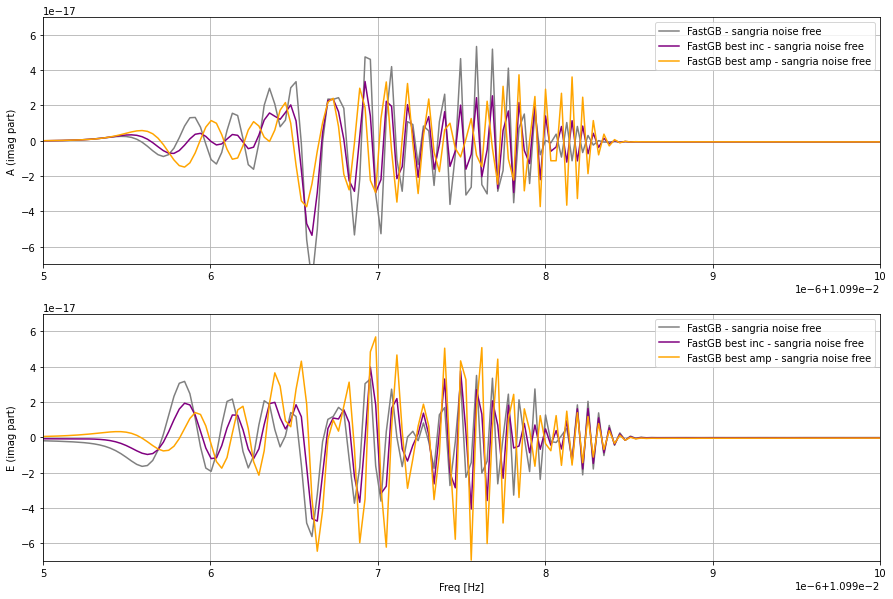

In [12]:
subset_sangria = tdi_sangria_fd.sel(f=fast.f, method="nearest")
plt.figure(figsize=(15,10))
plt.subplot(211)
#plt.plot(fast.f, fast["A"].imag, label='FastGB')
#plt.plot(tdi_sangria_fd.f, tdi_sangria_fd["A"].imag,  label='sangria noise free', ls='--')
#plt.plot(best.f, best["A"].imag, label='FastGB best',ls='-.', alpha=0.5)
plt.plot(fast.f, fast["A"].values.imag-subset_sangria.A.values.imag, color='grey', label='FastGB - sangria noise free')
plt.plot(best_i.f, best_i["A"].values.imag-subset_sangria.A.values.imag, color='purple', label='FastGB best inc - sangria noise free')
plt.plot(best_a.f, best_a["A"].values.imag-subset_sangria.A.values.imag, color='orange', label='FastGB best amp - sangria noise free')
plt.axis([0.010995, 0.01100, -0.7e-16, 0.7e-16])
plt.legend()
plt.grid()
plt.ylabel("A (imag part)")
plt.subplot(212)
#plt.plot(fast.f, fast["E"].imag, label='FastGB')
#plt.plot(tdi_sangria_fd.f, tdi_sangria_fd["E"].imag,  label='sangria noise free', ls='--')
#plt.plot(best.f, best["E"].imag, label='FastGB best', ls='-.', alpha=0.5)
plt.plot(fast.f, fast["E"].values.imag-subset_sangria.E.values.imag, color='grey', label='FastGB - sangria noise free')
plt.plot(best_i.f, best_i["E"].values.imag-subset_sangria.E.values.imag, color='purple', label='FastGB best inc - sangria noise free')
plt.plot(best_a.f, best_a["E"].values.imag-subset_sangria.E.values.imag, color='orange', label='FastGB best amp - sangria noise free')
plt.axis([0.010995, 0.01100, -0.7e-16, 0.7e-16])
plt.legend()
plt.grid()
plt.xlabel("Freq [Hz]")
plt.ylabel("E (imag part)")

### Log-likelihood difference as a function of frequency

Text(0, 0.5, 'Log likelihood')

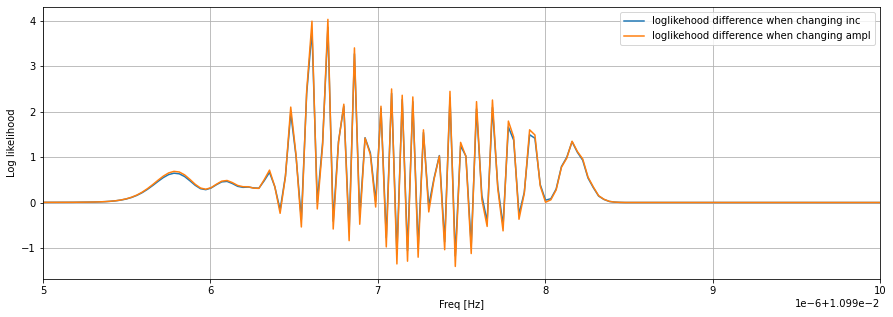

In [13]:
p_best_i = p.copy()
p_best_i[5] = np.cos(pGB_best_i["Inclination"])
p_best_a = p.copy()
p_best_a[0] = np.log10(pGB_best_a["Amplitude"])
loglik_ref, loglikAE_ref, freq = loglikelihood_dgb(p, full_output=True)
loglik_best_i, loglikAE_best_i, freq = loglikelihood_dgb(p_best_i, full_output=True)
loglik_best_a, loglikAE_best_a, freq = loglikelihood_dgb(p_best_a, full_output=True)
plt.figure(figsize=(15,5))
plt.plot(freq, loglikAE_best_i-loglikAE_ref, label="loglikehood difference when changing inc")
plt.plot(freq, loglikAE_best_a-loglikAE_ref, label="loglikehood difference when changing ampl")
plt.grid()
plt.legend()
plt.axis([0.010995, 0.01100, None, None])
plt.xlabel("Freq [Hz]")
plt.ylabel("Log likelihood")